Install the necessary packages.

In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


Mount your Google Drive to this notebook to allow for persistent storage of your downloaded data, even after this VM instance dies.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Get the training data, binary masks (will be used for segmentation demo), dermoscopic features, and lesion diagnoses.

If running this notebook for the first time, uncomment all of the cells involving downloading/unzipping/copying data! Then once the copying and unzipping operations are complete, you can delete the originally downloaded files to free up space on your Google Drive.

In [3]:
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part2_GroundTruth.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part3_GroundTruth.csv

Perform the same sets of downloads for the validation and test data.

In [4]:
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Data.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part1_GroundTruth.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part2_GroundTruth.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part3_GroundTruth.csv

In [5]:
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Data.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part1_GroundTruth.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part2_GroundTruth.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv

Create a Google Drive folder to store the data persistently. Then unzip all the zip files there, and copy the csv files there

In [6]:
# !rm -rf gdrive/MyDrive/ISIC_2017

In [7]:
import os
# import zipfile
# import shutil

data_dir = "gdrive/MyDrive/ISIC_2017"
# os.mkdir(data_dir)

# zip_files = [
#   "ISIC-2017_Test_v2_Data.zip",
#   "ISIC-2017_Test_v2_Part1_GroundTruth.zip",
#   "ISIC-2017_Test_v2_Part2_GroundTruth.zip",
#   "ISIC-2017_Training_Data.zip",
#   "ISIC-2017_Training_Part1_GroundTruth.zip",
#   "ISIC-2017_Training_Part2_GroundTruth.zip",
#   "ISIC-2017_Validation_Data.zip",
#   "ISIC-2017_Validation_Part1_GroundTruth.zip",
#   "ISIC-2017_Validation_Part2_GroundTruth.zip"
# ]

# csv_files = [
#     "ISIC-2017_Test_v2_Part3_GroundTruth.csv",
#     "ISIC-2017_Training_Part3_GroundTruth.csv",
#     "ISIC-2017_Validation_Part3_GroundTruth.csv"
# ]

# for zf in zip_files:
#   with zipfile.ZipFile(zf, "r") as zip_ref:
#     zip_ref.extractall(data_dir)

# for cf in csv_files:
#   shutil.copy2(
#       cf,
#       f"{data_dir}/{cf}"
#   )

In [8]:
import pandas as pd

In [9]:
drive.mount('/content/gdrive', force_remount=True)
label_df = pd.read_csv(f"{data_dir}/ISIC-2017_Training_Part3_GroundTruth.csv")

Mounted at /content/gdrive


In [10]:
label_df["melanoma"].value_counts(dropna=False)

0.0    1626
1.0     374
Name: melanoma, dtype: int64

In [11]:
label_df["seborrheic_keratosis"].value_counts(dropna=False)

0.0    1746
1.0     254
Name: seborrheic_keratosis, dtype: int64

In [12]:
def get_combined_label(mel_indic, sk_indic):
  mel_indic_str = "y" if mel_indic else "n"
  sk_indic_str = "y" if sk_indic else "n"
  return f"m_{mel_indic_str}_sk_{sk_indic_str}"

In [13]:
combined_label_list = []
for _, row in label_df.iterrows():
  combined_label_list.append(
    get_combined_label(
        row["melanoma"],
        row["seborrheic_keratosis"]
    )
  )

In [14]:
combined_label_series = pd.Series(combined_label_list)

In [15]:
combined_label_series.value_counts(dropna=False)

m_n_sk_n    1372
m_y_sk_n     374
m_n_sk_y     254
dtype: int64

So the majority of the lesions are neither melanoma nor seborrheic keratosis. And no lesion is both (to be expected, but it's good to confirm).

Inside the ISIC-2017_Training_Data folder, there are three types of files.

1. A csv containing demographic metadata about the patients (`ISIC-2017_Training_Data_metadata.csv`). This information could be directly incorporated into a model to help teach it to pay attention to different visual features depending on patient demographics. Alternatively, if demographic data won't be available at inference time, the information could be used to create auxiliary targets for the model. We can discuss either or both options if time permits at the end of the tutorial, but we'll focus on straightforward classification with image data only for now.
2. Images ending with `superpixels.png`. Again, this is a concept that we can explore if time allows, but we'll ignore these images for now.
3. Images ending in `.jpg`. These are the dermoscopic images we'll use to train the model. We'll start by visualizing a few of them.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

train_imgs = [
  f for f in os.listdir(f"{data_dir}/ISIC-2017_Training_Data") if f[-len(".jpg"):] == ".jpg"
]

In [20]:
imgs_as_arr = np.array(train_imgs)
np.random.seed(42) # Ensure reproducibility of the plotted images
np.random.shuffle(imgs_as_arr)

Melanoma: False
Seborrheic keratosis: False


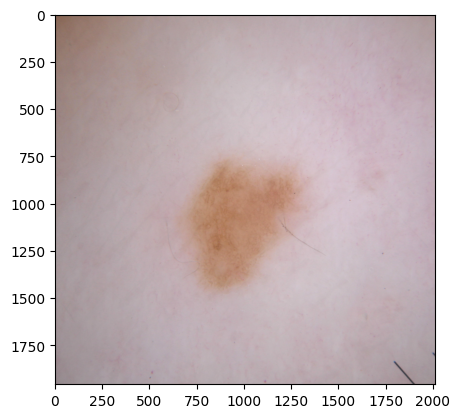

Melanoma: False
Seborrheic keratosis: True


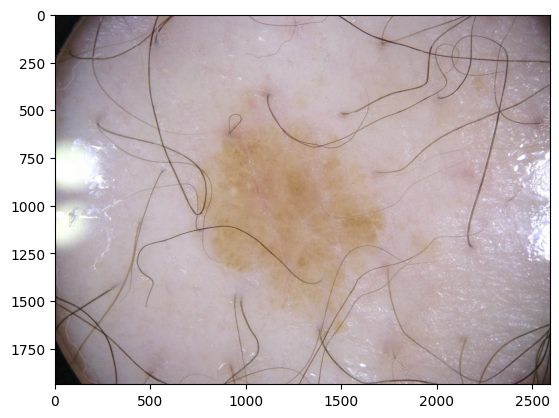

Melanoma: False
Seborrheic keratosis: False


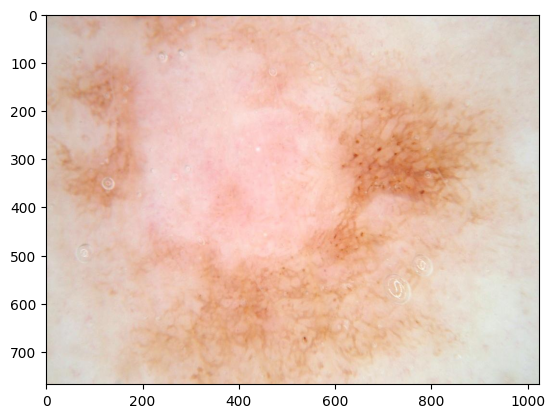

Melanoma: False
Seborrheic keratosis: False


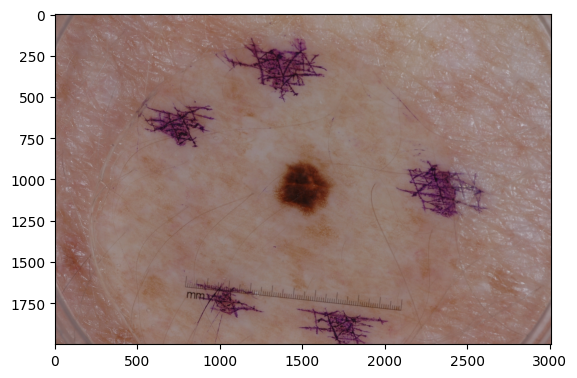

Melanoma: False
Seborrheic keratosis: False


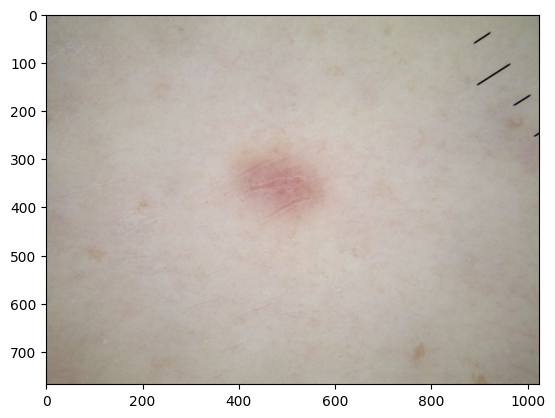

Melanoma: True
Seborrheic keratosis: False


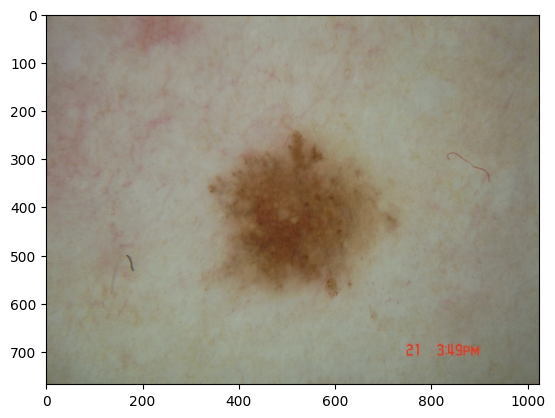

Melanoma: False
Seborrheic keratosis: False


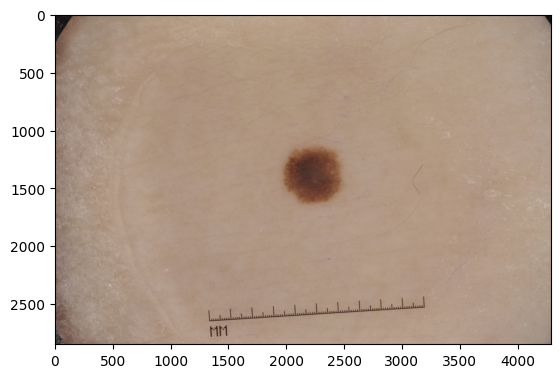

Melanoma: False
Seborrheic keratosis: False


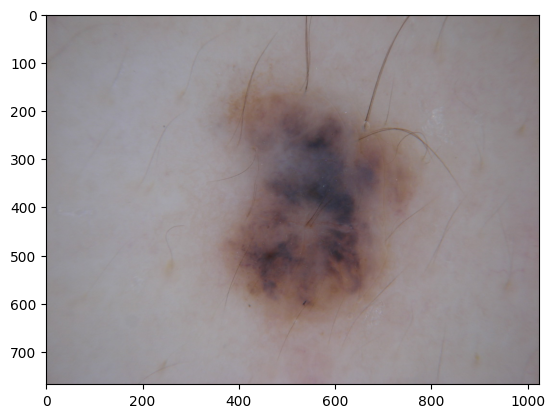

Melanoma: False
Seborrheic keratosis: True


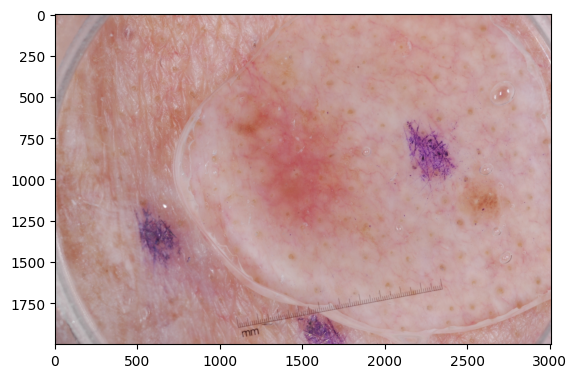

Melanoma: False
Seborrheic keratosis: False


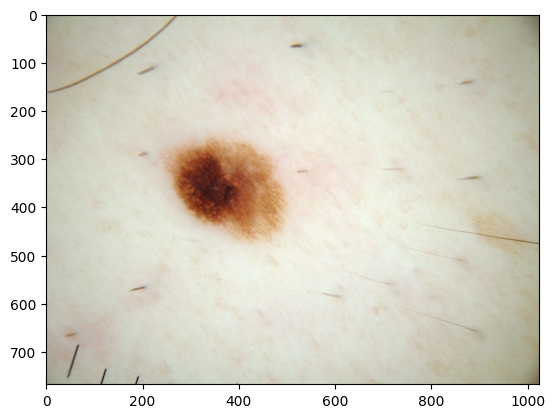

Melanoma: False
Seborrheic keratosis: False


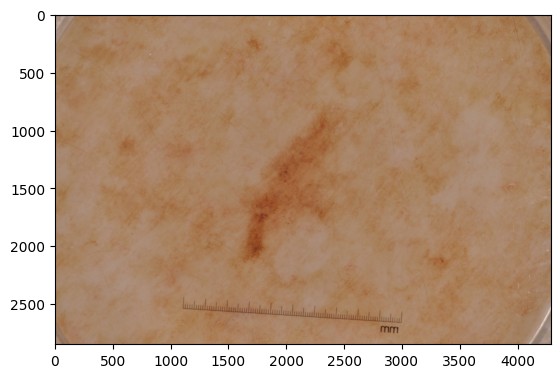

Melanoma: False
Seborrheic keratosis: False


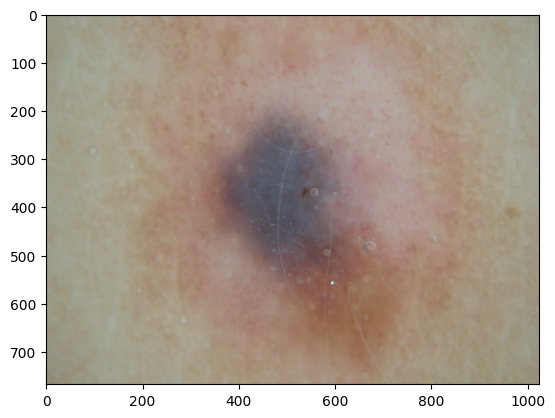

Melanoma: True
Seborrheic keratosis: False


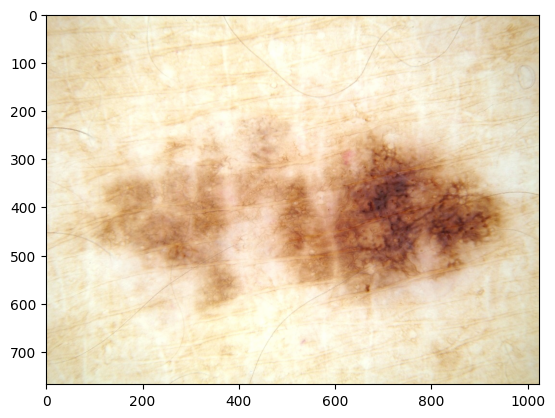

Melanoma: False
Seborrheic keratosis: False


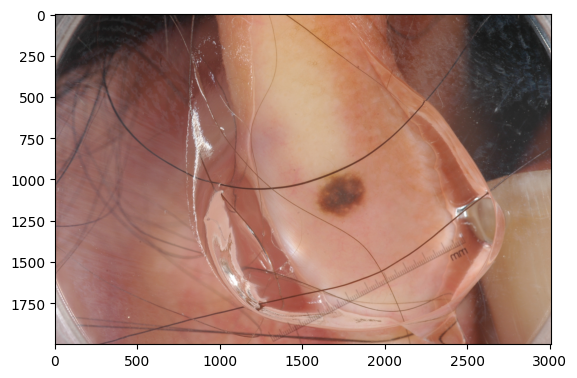

Melanoma: False
Seborrheic keratosis: False


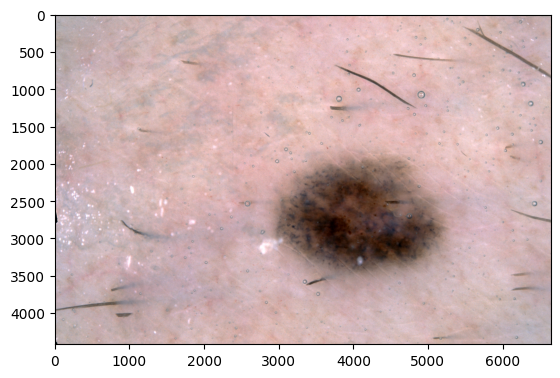

Melanoma: False
Seborrheic keratosis: True


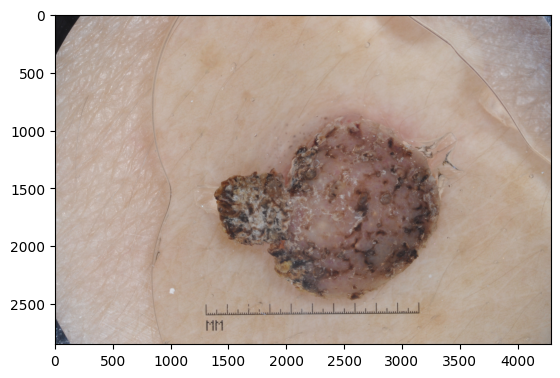

Melanoma: False
Seborrheic keratosis: False


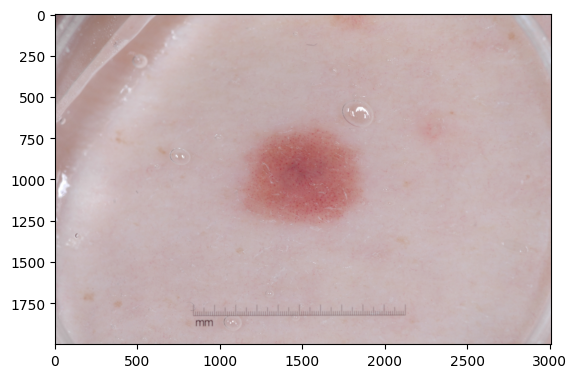

Melanoma: True
Seborrheic keratosis: False


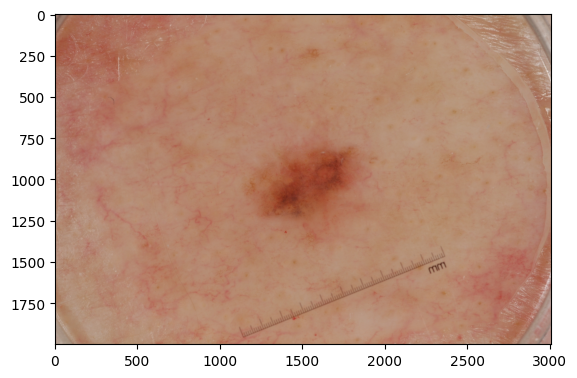

Melanoma: True
Seborrheic keratosis: False


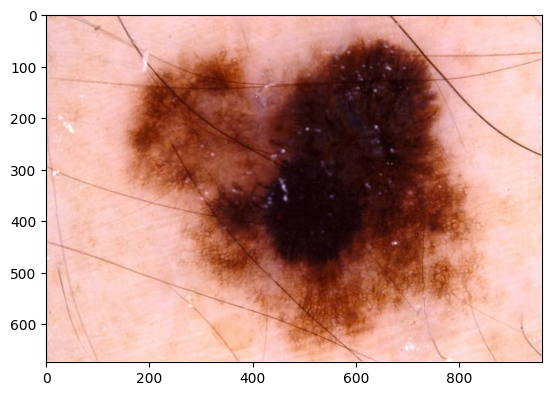

Melanoma: False
Seborrheic keratosis: False


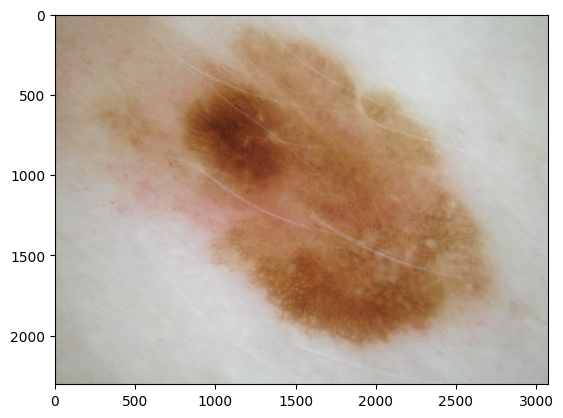

Melanoma: False
Seborrheic keratosis: False


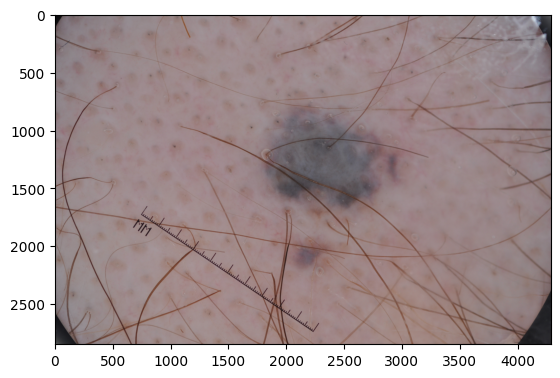

Melanoma: False
Seborrheic keratosis: False


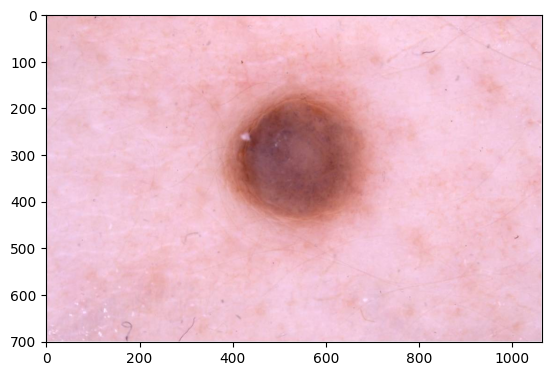

Melanoma: False
Seborrheic keratosis: False


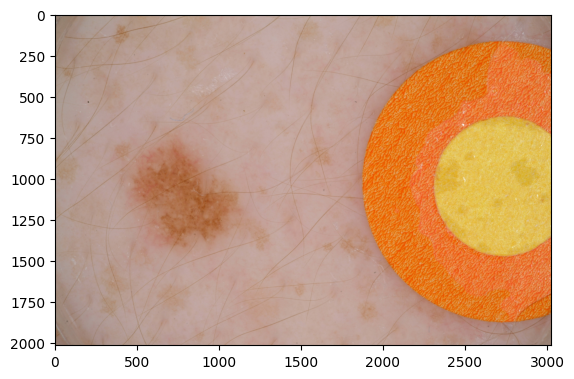

Melanoma: False
Seborrheic keratosis: False


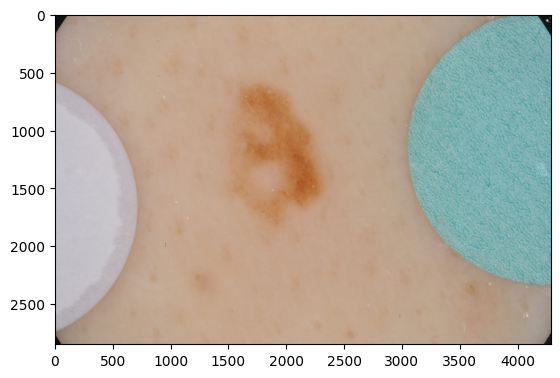

Melanoma: True
Seborrheic keratosis: False


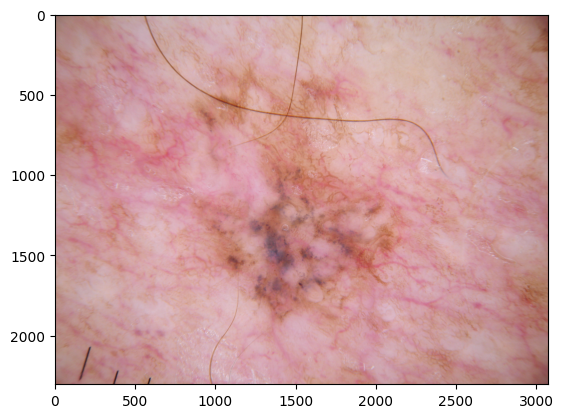

In [21]:
num_imgs_to_display = 25
from skimage import io, transform
for i in range(num_imgs_to_display):
  img_name = imgs_as_arr[i]
  short_img_name = img_name[:-len('.jpg')]
  melanoma_indic = bool(
      label_df.loc[label_df["image_id"]==short_img_name, "melanoma"].iloc[0]
  )
  print(
      f"Melanoma: {melanoma_indic}"
  )
  sk_indic = bool(
      label_df.loc[label_df["image_id"]==short_img_name, "seborrheic_keratosis"].iloc[0]
  )
  print(
      f"Seborrheic keratosis: {sk_indic}"
  )
  plt.imshow(
      io.imread(f"{data_dir}/ISIC-2017_Training_Data/{img_name}")
  )


  plt.show()

In general, the melanoma lesions seem to have more diffuse boundaries, and the seborrheic keratosis lesions seem to look a bit crustier. The images also have many background artifacts. Time permitting, we can discuss options for handling them in a more elegant way. But for now, we'll pretend that they're not there.

In [22]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

Custom PyTorch datasets require a `__len__` and a `__getitem__` method.

In [23]:
class SkinClassifDataset(Dataset):
  def __init__(
      self, root_dir, label_csv,
      transform=None
  ):
    self.root_dir = root_dir
    orig_labels = pd.read_csv(
        label_csv
    )
    combined_label_list = []
    for _, row in orig_labels.iterrows():
      combined_label_list.append(
        get_combined_label(
            row["melanoma"],
            row["seborrheic_keratosis"]
        )
      )
    self.orig_labels = orig_labels
    self.full_labels = combined_label_list
    unique_labels = list(set(self.full_labels))
    self.labels_to_ints = {
        k: v for k, v in zip(
            unique_labels,
            list(range(len(unique_labels)))
        )
    }
    self.transform = transform

  def __len__(self):
    return len(self.full_labels)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    base_img_name = self.orig_labels.loc[
          idx, "image_id"
    ]
    base_img_name += ".jpg"
    img_name = os.path.join(
      self.root_dir,
      base_img_name
    )
    img_label = self.labels_to_ints[self.full_labels[idx]]
    image = io.imread(img_name)

    if self.transform:
      image = self.transform(image)

    return (image, torch.tensor(img_label))

In [24]:
import torchvision
from torchvision.models import ConvNeXt_Tiny_Weights as cnvnext_tiny_wts
from torchvision.models import ConvNeXt_Small_Weights as cnvnext_small_wts

In [25]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(
        degrees=5,
        translate=(.1, .1)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(
        distortion_scale=.25, p=.25
    ),
    transforms.RandomVerticalFlip(),
    # cnvnext_tiny_wts.IMAGENET1K_V1.transforms() # Uncomment this
    # line if you want to use a ConvNext tiny model
    # but be sure to comment out the current last
    # transform).
    # These
    # transformations ensure that we're applying the
    # same resizing and scaling as was applied to the
    # pretrained model we're using for transfer learning
    cnvnext_small_wts.IMAGENET1K_V1.transforms()
])

In [26]:
valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    cnvnext_small_wts.IMAGENET1K_V1.transforms()
])

We have a small training dataset and limited compute resources. Thus, we'll freeze all but the last layer of a revised ConvNext small model, where the last layer is replaced with a linear layer with three outputs.

In [27]:
import torch.nn as nn

# model = torchvision.models.convnext_tiny(
#     weights=cnvnext_tiny_wts.IMAGENET1K_V1
# )

model = torchvision.models.convnext_small(
    weights=cnvnext_small_wts.IMAGENET1K_V1
)

for param in model.parameters():
  param.requires_grad = False


# Original last layer has an input size of 768
model.classifier[2] = nn.Linear(768, 3)
device = "cuda" if torch.cuda.is_available else "cpu"
# device = "cpu"
model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [28]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-5
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    patience=3
)

In [29]:
def train_one_epoch(
    train_loader,
    print_every=2
):
    running_loss = 0

    for i, data in enumerate(train_loader):

        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust weights
        optimizer.step()

        # Tabulate the running loss, and possibly print
        # intermediate results
        running_loss += loss.item()
        if i % print_every == 0:
            avg_loss = running_loss / i # Avg loss per batch
            print(f"Batch {i} loss {loss.item()}")
            print(f"Current average loss: {avg_loss}")

    return {
        "total_loss": running_loss,
        "avg_loss": running_loss/i
    }

In [30]:
from torch.utils.data import DataLoader


train_ds = SkinClassifDataset(
    root_dir="/content/gdrive/MyDrive/ISIC_2017/ISIC-2017_Training_Data",
    label_csv="/content/gdrive/MyDrive/ISIC_2017/ISIC-2017_Training_Part3_GroundTruth.csv",
    transform=train_transforms
)

valid_ds = SkinClassifDataset(
    root_dir="/content/gdrive/MyDrive/ISIC_2017/ISIC-2017_Training_Data",
    label_csv="/content/gdrive/MyDrive/ISIC_2017/ISIC-2017_Training_Part3_GroundTruth.csv",
    transform=valid_transforms
)
batch_size = 512
num_workers = 2 if device == "cuda" else 1
pin_memory = (device == "cuda")
train_loader = DataLoader(
    train_ds, batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=pin_memory
)
valid_loader = DataLoader(
    valid_ds, batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory
)

In [31]:
epoch_number = 0

n_epochs = 15

best_vloss = np.inf

for epoch in range(n_epochs):
    print(f"Epoch {epoch}")

    model.train(True)
    train_losses = train_one_epoch(train_loader)
    total_train_loss = train_losses["total_loss"]
    avg_train_loss = train_losses["avg_loss"]


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation to reduce memory consumption.
    with torch.no_grad():
        for i, val_data in enumerate(valid_loader):
            val_imgs, val_labels = val_data
            val_imgs = val_imgs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_imgs)
            vloss = loss_fn(val_outputs, val_labels)
            running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    scheduler.step(avg_vloss)
    print(f"Avg train loss: {avg_train_loss}")
    print(f"Avg val loss: {avg_vloss}")

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_vloss_epoch = epoch
        model_path = f"convnext_tiny_epoch_{epoch}.pth"
        torch.save(model.state_dict(), model_path)


Epoch 0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 0 loss 1.1705429553985596
Current average loss: 0.5852714776992798
Batch 2 loss 1.1680630445480347
Current average loss: 1.7477827072143555


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Avg train loss: 1.5507196187973022
Avg val loss: 1.1944711208343506
Epoch 1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 0 loss 1.1731690168380737
Current average loss: 0.5865845084190369
Batch 2 loss 1.1680240631103516
Current average loss: 1.7513001561164856


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Avg train loss: 1.5518844922383626
Avg val loss: 1.1853697299957275
Epoch 2


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

KeyboardInterrupt: ignored

In [ ]:
test_ds = SkinClassifDataset(
    root_dir="/content/gdrive/MyDrive/ISIC_2017/ISIC-2017_Test_v2_Data",
    label_csv="/content/gdrive/MyDrive/ISIC_2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv",
    transform=valid_transforms
)

test_loader = DataLoader(
    valid_ds, batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=False
)

test_ys = []
test_yhats = []
model.load_state_dict(
    torch.load(f"convnext_tiny_epoch_{best_vloss_epoch}.pth")
)
model.eval()
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_imgs, test_labels = test_data
        test_imgs = test_imgs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = nn.functional.softmax(
            model(test_imgs), dim=1
        )
        test_ys.append(test_labels.cpu())
        test_yhats.append(test_outputs.cpu())

concatted_ys = torch.cat(test_ys)
concatted_yhats = torch.cat(test_yhats)


all_nums = []

for val in concatted_ys.unique():
  val_indic = (concatted_ys == val)
  true_pos = torch.bitwise_and(
      val_indic,
      (concatted_yhats == val)
  )
  acc_num = torch.sum(true_pos)
  acc_denom = torch.sum(val_indic)
  all_nums.append(acc_num)

  print(
      f"Model predicted {acc_num} correct of {acc_denom} class {val} samples"
  )
  print(f"Accuracy on class {val} is {acc_num / acc_denom}")
  print("*****")

total_num = np.sum(np.array(all_nums))
print(f"Overall accuracy is {total_num / concatted_ys.size(dim=0)}")

Discussion topics, time permitting:


1. Auxiliary targets
2. Incorporating demographic information at both training and inference time
3. How to handle artifacts more elegantly:
  a. Image augmentation options
  b. Training a lesion vs background segmentation model
4. Hyperparameter tuning
5. Other options for learning rate scheduler (eg the one-cycle policy)
6. Other model architecture options
  a. Other convolutional architectures
  b. Transformer approaches
7. Ensuring generalization to other populations

